FIXME: Update the comment below
# Example: Path planning problem solved by [Uniform grid abstraction](https://github.com/dionysos-dev/Dionysos.jl/blob/master/docs/src/manual/manual.md#solvers).


This example was borrowed from [1, IX. Examples, A] whose dynamics comes from the model given in [2, Ch. 2.4].
This is a **reachability problem** for a **continuous system**.

Let us consider the 3-dimensional state space control system of the form
$$
\dot{x} = f(x, u)
$$
with $f: \mathbb{R}^3 × U ↦ \mathbb{R}^3$ given by
$$
f(x,(u_1,u_2)) = \begin{bmatrix} u_1 \cos(α+x_3)\cos(α^{-1}) \\ u_1 \sin(α+x_3)\cos(α^{-1}) \\ u_1 \tan(u_2)  \end{bmatrix}
$$
and with $U = [−1, 1] \times [−1, 1]$ and $α = \arctan(\tan(u_2)/2)$. Here, $(x_1, x_2)$ is the position and $x_3$ is the
orientation of the vehicle in the 2-dimensional plane. The control inputs $u_1$ and $u_2$ are the rear
wheel velocity and the steering angle.
The control objective is to drive the vehicle which is situated in a maze made of obstacles from an initial position to a target position.


In order to study the concrete system and its symbolic abstraction in a unified framework, we will solve the problem
for the sampled system with a sampling time $\tau$.
For the construction of the relations in the abstraction, it is necessary to over-approximate attainable sets of
a particular cell. In this example, we consider the used of a growth bound function  [1, VIII.2, VIII.5] which is one of the possible methods to over-approximate
attainable sets of a particular cell based on the state reach by its center.

For this reachability problem, the abstraction controller is built by solving a fixed-point equation which consists in computing the pre-image
of the target set.

First, let us import [StaticArrays](https://github.com/JuliaArrays/StaticArrays.jl) and [Plots](https://github.com/JuliaPlots/Plots.jl).

In [1]:
using StaticArrays, Plots

At this point, we import Dionysos.

In [2]:
using Dionysos
const DI = Dionysos
const UT = DI.Utils
const DO = DI.Domain
const ST = DI.System
const SY = DI.Symbolic
const PR = DI.Problem
const OP = DI.Optim
const AB = OP.Abstraction

Dionysos.Optim.Abstraction

And the file defining the hybrid system for this problem

In [3]:
include(joinpath(dirname(dirname(pathof(Dionysos))), "problems", "path_planning_sgmpc.jl"))

Main.var"##645".PathPlanningSgMPC

### Definition of the problem

Now we instantiate the problem using the function provided by [PathPlanning.jl](https://github.com/dionysos-dev/Dionysos.jl/blob/master/problems/PathPlanningSgMPC.jl)

In [4]:
concrete_problem =
    PathPlanningSgMPC.problem(; simple = true, approx_mode = PathPlanningSgMPC.GROWTH);
concrete_system = concrete_problem.system;

### Definition of the abstraction

Definition of the grid of the state-space on which the abstraction is based (origin `x0` and state-space discretization `h`):

In [5]:
x0 = SVector(0.0, 0.0, 0.0);
h = SVector(0.1, 0.1, 0.2);
state_grid = DO.GridFree(x0, h);

Definition of the grid of the input-space on which the abstraction is based (origin `u0` and input-space discretization `h`):

In [6]:
u0 = SVector(0.3, 0.0);
h = SVector(0.3, 0.3);
input_grid = DO.GridFree(u0, h);

We now solve the optimal control problem with the `Abstraction.UniformGridAbstraction.Optimizer`.

In [7]:
using JuMP
optimizer = MOI.instantiate(AB.UniformGridAbstraction.Optimizer)
MOI.set(optimizer, MOI.RawOptimizerAttribute("concrete_problem"), concrete_problem)
MOI.set(optimizer, MOI.RawOptimizerAttribute("state_grid"), state_grid)
MOI.set(optimizer, MOI.RawOptimizerAttribute("input_grid"), input_grid)
MOI.optimize!(optimizer)

compute_symmodel_from_controlsystem! started
compute_symmodel_from_controlsystem! terminated with success: 14574752 transitions created
  2.204356 seconds (80 allocations: 442.345 MiB, 3.27% gc time)
compute_controller_reach! started

compute_controller_reach! terminated without covering init set


Get the results

In [8]:
abstract_system = MOI.get(optimizer, MOI.RawOptimizerAttribute("abstract_system"))
abstract_problem = MOI.get(optimizer, MOI.RawOptimizerAttribute("abstract_problem"))
abstract_controller = MOI.get(optimizer, MOI.RawOptimizerAttribute("abstract_controller"))
concrete_controller = MOI.get(optimizer, MOI.RawOptimizerAttribute("concrete_controller"))

(::Dionysos.Optim.Abstraction.UniformGridAbstraction.var"#concrete_controller#10"{Dionysos.Optim.Abstraction.UniformGridAbstraction.var"#concrete_controller#9#11"{Dionysos.Symbolic.SymbolicModelList{3, 2, Dionysos.Domain.DomainList{3, Float64, Dionysos.Domain.GridFree{3, Float64}}, Dionysos.Domain.DomainList{2, Float64, Dionysos.Domain.GridFree{2, Float64}}, Dionysos.Symbolic.AutomatonList{Dionysos.Utils.SortedTupleSet{3, Tuple{Int64, Int64, Int64}}}}, Dionysos.Utils.SortedTupleSet{2, Tuple{Int64, Int64}}}}) (generic function with 1 method)

### Trajectory display
We choose a stopping criterion `reached` and the maximal number of steps `nsteps` for the sampled system, i.e. the total elapsed time: `nstep`*`tstep`
as well as the true initial state `x0` which is contained in the initial state-space `_I_` defined previously.

In [9]:
nstep = 100
function reached(x)
    if x ∈ concrete_problem.target_set
        return true
    else
        return false
    end
end
x0 = SVector(0.5, 0.5, 0.0)
control_trajectory = ST.get_closed_loop_trajectory(
    concrete_system.f,
    concrete_controller,
    x0,
    nstep;
    stopping = reached,
)

Dionysos.System.Control_trajectory{StaticArraysCore.SVector{3, Float64}, Any}(Dionysos.System.Trajectory{StaticArraysCore.SVector{3, Float64}}(StaticArraysCore.SVector{3, Float64}[[0.5, 0.5, 0.0]]), Dionysos.System.Trajectory{Any}(Any[]))

Here we display the coordinate projection on the two first components of the state space along the trajectory.

In [10]:
fig = plot(; aspect_ratio = :equal);

We display the concrete domain

In [11]:
plot!(concrete_system.X; color = :yellow, opacity = 0.5);

We display the abstract domain

In [12]:
plot!(abstract_system.Xdom; color = :blue, opacity = 0.5);

We display the concrete specifications

In [13]:
plot!(concrete_problem.initial_set; color = :green, opacity = 0.2);
plot!(concrete_problem.target_set; dims = [1, 2], color = :red, opacity = 0.2);

We display the abstract specifications

In [14]:
plot!(
    SY.get_domain_from_symbols(abstract_system, abstract_problem.initial_set);
    color = :green,
);
plot!(
    SY.get_domain_from_symbols(abstract_system, abstract_problem.target_set);
    color = :red,
);

We display the concrete trajectory

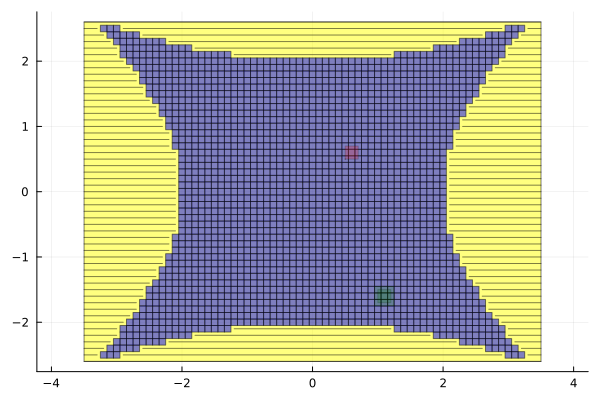

In [15]:
plot!(control_trajectory; ms = 0.5)

### References
1. G. Reissig, A. Weber and M. Rungger, "Feedback Refinement Relations for the Synthesis of Symbolic Controllers," in IEEE Transactions on Automatic Control, vol. 62, no. 4, pp. 1781-1796.
2. K. J. Aström and R. M. Murray, Feedback systems. Princeton University Press, Princeton, NJ, 2008.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*